# France study part III: daily climate normals

This notebook provides code for calculation of daily climate normals.
The methodology follows Rigal et al. (2018), with two key differences:
- the long-term warming function $g()$ is assumed to be known (derived from the observational constraint). In practice, we regress daily observations of a known $g$.
- we also rescaled the estimated warming to ensure the overall warming to match the warming estimated in the observational constraint.

The main statistical model writes
\begin{equation}    T_{d,y} = f(d) + g(y)h(d) + \varepsilon_{d,y},   \tag{1}  \end{equation}
where $T_{d,y}$ is the temperature of day $d$ and year $y$, $f(d)$ is the normal in a stationary climate, $g(y)h(d)$ is the change in normals induced by climate change, and $\varepsilon_{d,y}$ is internal variability.

We start with some preliminary R commands

In [17]:
library(grid)

Select smoothness for functions $f()$ and $h()$ (following Rigal et al., 2018)

In [18]:
dff = 15
dfh = 6

Compile useful function for periodic smoothing splines. 

Note: smoothing splines are easy to use in R with 'smooth.spline()'. But, we find no easy way to calculate periodic smoothing splines (which are needed here). The 2 functions here enable us to derive periodic smoothing splines. There may exist another R package doing this...


In [19]:
source("spline_per.R")

## I. Data

Load daily data

In [20]:
load("IT_quot.Rdata")  # variable M
period = as.numeric(dimnames(M)$year)
ny = length(period)
days = dimnames(M)$day
nd = length(days)

Load the "known" $g()$ function

In [21]:
load("g_cons.Rdata")
g = g[as.character(period)]

## II. Calculation


Center input function $g()$

In [22]:
gc = g - mean(g)

Day-by-day linear regression on $g()$

In [23]:
fraw = array(NA,dim=nd,dimnames=list(day=days))
hraw = array(NA,dim=nd,dimnames=list(day=days))

for (d in 1:nd){
  lm.out = lm(M[d,] ~ gc)
  fraw[d] = lm.out$coefficients[1]
  hraw[d] = lm.out$coefficients[2]
}

Periodic spline smoothing of fraw and hraw, with appropriate dofs

In [24]:
fhat = smooth.spline.per(fraw,dff)
hhat0 = smooth.spline.per(hraw,dfh)

At this stage, 'hhat0' is a first guess of $h()$. Its average $\bar{h}$ is not equal to 1, and so the annual mean warming over the period considered is estimated to be $\big( g(y_n)-g(y_1) \big) \bar{h}$.

To keep overall warming equal to that assumed in $g()$ (i.e., $g(y_n)-g(y_1)$), we normalize $h$. As $g$ was previously centered, this does not affect the average temperature over the period considered.

In [25]:
hhat = hhat0 / mean(hhat0)

We end up with estimates for $f()$ and $h()$, so all terms in Eq. (1) have been estimated.

## III. Plots

An example of plot.

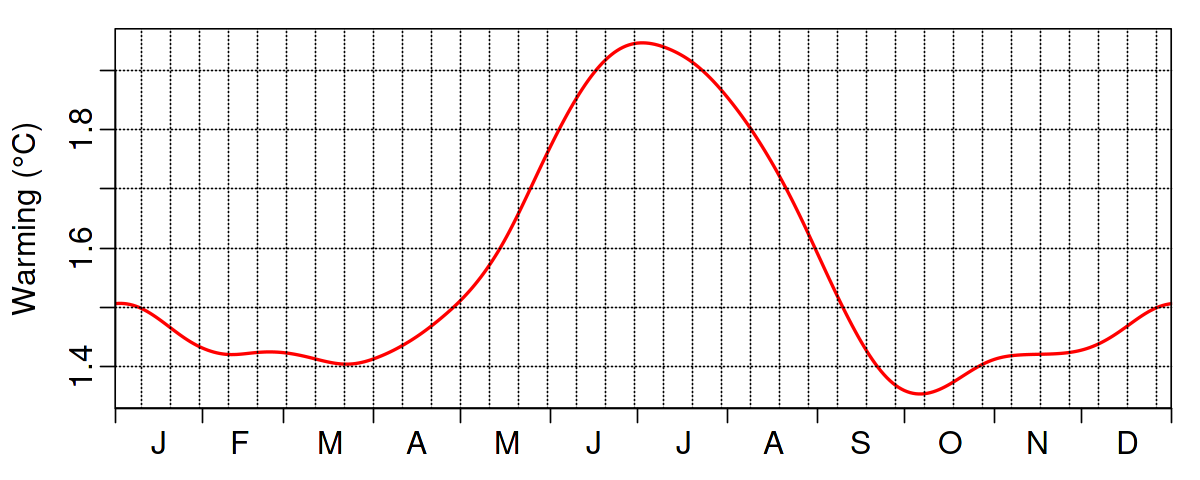

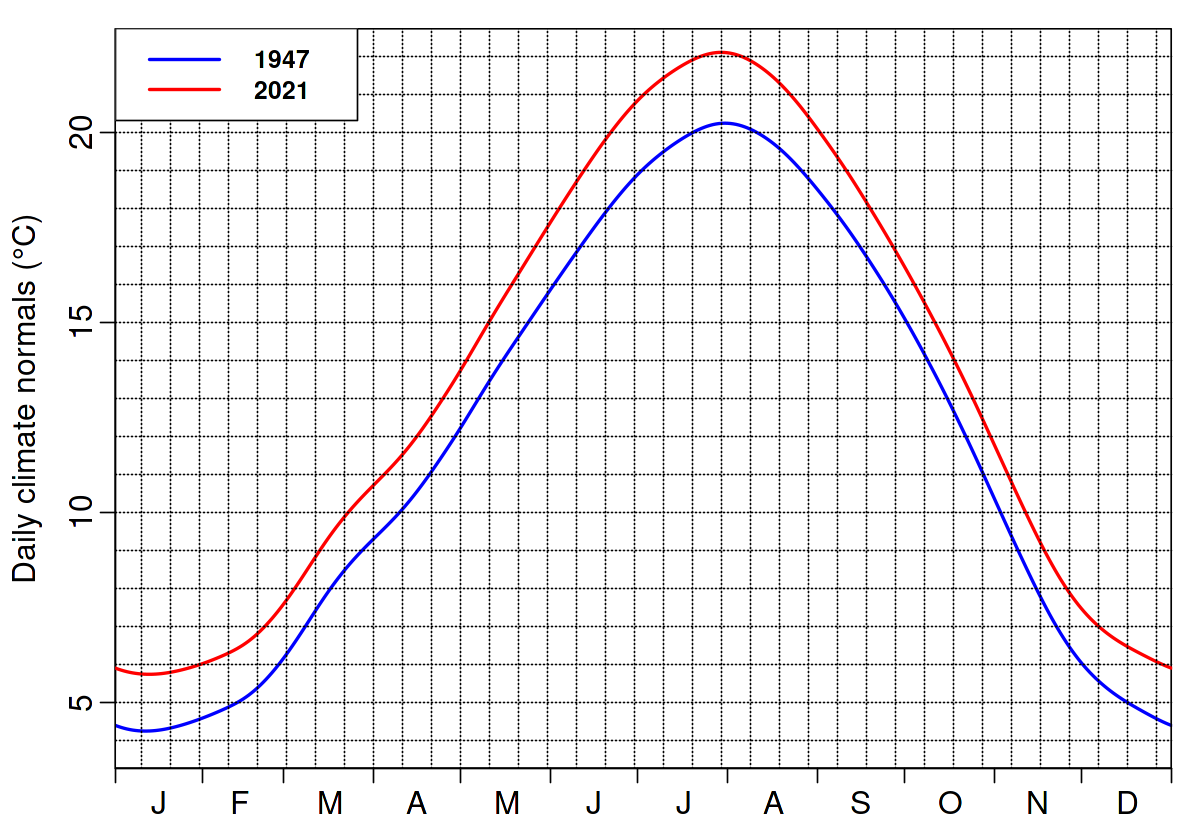

In [28]:
day_by_month=c(0,31,28,31,30,31,30,31,31,30,31,30,31)
atx = cumsum(day_by_month)
atx[1]=1
yr = as.numeric(names(g))
y1 = min(yr)
yn = max(yr)

# Plot delta_cycle
options(repr.plot.width=10, repr.plot.height=4)
par(font=2,cex=1.2,mgp=c(2.7,.7,0),mar=c(2.5,4,1,1),cex.axis=1.3,cex.lab=1.3)
plot(hhat*(gc[as.character(yn)]-gc[as.character(y1)]),type="l",col="red",xaxt="n",ylab="Warming (°C)",lwd=2,xaxs="i",xlab="")
abline(h=seq(1,2.5,.1),lty=3)
abline(v=seq(0,400,10),lty=3)
axis(1,at=atx,labels=F,tick=T)
axis(1,at=atx[-1]-15,labels=c("J","F","M","A","M","J","J","A","S","O","N","D"),tick=F,mgp=c(2,.7,0))


# Show old vs new normals
options(repr.plot.width=10, repr.plot.height=7)
par(font=2,cex=1.2,mgp=c(2.7,.7,0),mar=c(2.5,4,1,1),cex.axis=1.3)
plot(fhat+gc[as.character(y1)]*hhat,type="l",lwd=2,col="blue",ylim=c(4,22),ylab="Daily climate normals (°C)",xaxt="n",xaxs="i",xlab="")
lines(fhat+gc[as.character(yn)]*hhat,type="l",lwd=2,col="red")
abline(h=4:22,lty=3)
abline(v=seq(0,400,10),lty=3)
legend("topleft",names(g[c(1,ny)]),col=c("blue","red"),lwd=2,bg="white")
axis(1,at=atx,labels=F,tick=T)
axis(1,at=atx[-1]-15,labels=c("J","F","M","A","M","J","J","A","S","O","N","D"),tick=F,mgp=c(2,.7,0))
